In [1]:
import os
import json
import numpy as np
from scipy.stats import ttest_ind, ttest_rel
import matplotlib.pyplot as plt

In [2]:
subjects = ['c1s01', 'c1s03', 'c1s05', 'c2s01', 'c2s02', 'c2s03', 'c2s04', 'c2s05']

In [3]:
results = {}
for subject_id in subjects:
    ecg_result_path = '../results/ecg/{}/results.json'.format(subject_id)
    ppg_result_path = '../results/ppg/{}/results.json'.format(subject_id)
    eda_result_path = '../results/eda/{}/results.json'.format(subject_id)

    if not os.path.exists(ecg_result_path) or not os.path.exists(ppg_result_path) or not os.path.exists(eda_result_path):
        continue

    with open('../results/ecg/{}/results.json'.format(subject_id)) as f:
        beat_ecg_result = json.load(f)
    with open('../results/ppg/{}/results.json'.format(subject_id)) as f:
        beat_ppg_result = json.load(f)
    with open('../results/eda/{}/results.json'.format(subject_id)) as f:
        beat_eda_result = json.load(f)

    results[subject_id] = {
        'ECG': beat_ecg_result,
        'PPG': beat_ppg_result,
        'EDA': beat_eda_result
    }


In [4]:
print(results)

{'c1s01': {'ECG': {'accs': {'train': [0.803027567988292, 0.7844416916128608, 0.6666183782029739, 0.7719369116541756, 0.7416525508606591], 'val': [0.7588835627029534, 0.7702687816699714, 0.6524834998462351, 0.7620909890313324, 0.7307963787018568]}, 'eer_thresholds': [0.53606116771698, 0.3416595757007599, 0.4535430073738098, 0.5926393866539001, 0.3898150622844696], 'aucs': {'train': [0.8882772369631675, 0.929905880428646, 0.8246312055786134, 0.8633766464574391, 0.908732835576252], 'val': [0.85172542757246, 0.8549075465111307, 0.7268273013561131, 0.8333587778028094, 0.8113708715873649]}, 'specificities': {'train': [0.8034497162803779, 0.7756721676246987, 0.6566985301082753, 0.771314892788977, 0.731416485936129], 'val': [0.7588847938398763, 0.7702860673669445, 0.652487491423886, 0.7620877230350794, 0.730805197361945]}, 'sensitivities': {'train': [0.7965721152325839, 0.9171368893599775, 0.8166500560607948, 0.781376645408564, 0.9013397901533495], 'val': [0.7588643371017472, 0.769986357435197

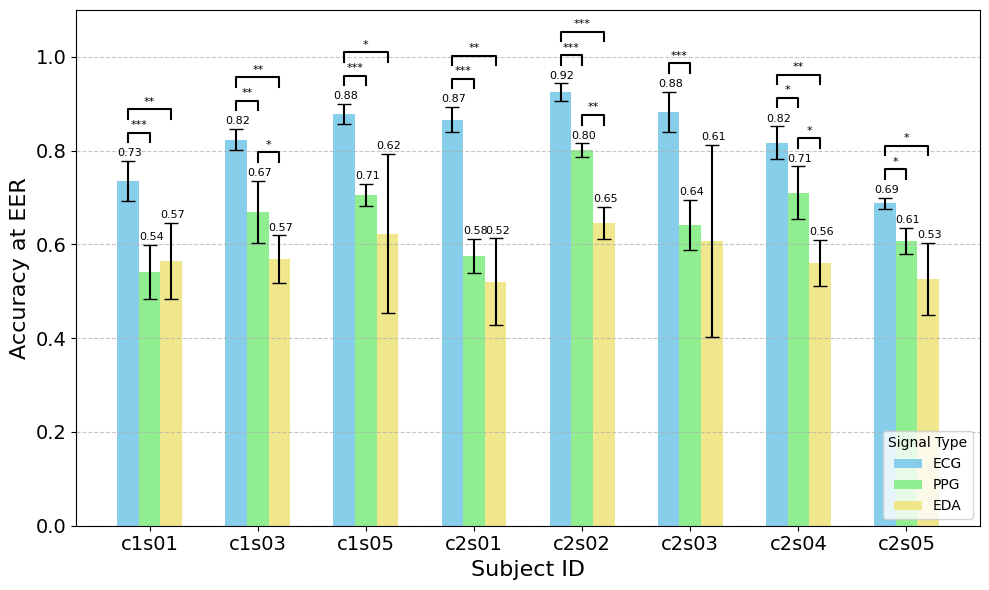

In [5]:
# Process data for the bar plot
subject_ids = list(results.keys())
categories = ['ECG', 'PPG', 'EDA']
x = np.arange(len(subject_ids))
bar_width = 0.2
colors = ['skyblue', 'lightgreen', 'khaki'] 
# Extract mean accuracy for each category per subject
mean_accuracies = {
    category: [np.mean(results[subject_id][category]['accs']['val']) for subject_id in subject_ids]
    for category in categories
}

std_accuracies = {
    category: [np.std(results[subject_id][category]['accs']['val']) for subject_id in subject_ids]
    for category in categories
}

# Perform t-tests to compute p-values
p_values = {}
for i, cat1 in enumerate(categories):
    for j, cat2 in enumerate(categories):
        if i < j:  # Avoid duplicate comparisons
            p_values[f"{cat1} vs {cat2}"] = []
            for subject_id in subject_ids:
                data1 = results[subject_id][cat1]['accs']['val']
                data2 = results[subject_id][cat2]['accs']['val']
                t_stat, p_val = ttest_rel(data1, data2)
                p_values[f"{cat1} vs {cat2}"].append(p_val)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for i, category in enumerate(categories):
    ax.bar(
        x + i * bar_width,
        mean_accuracies[category],
        bar_width,
        yerr=std_accuracies[category],
        capsize=5,
        label=category,
        color=colors[i]
    )

    # Add text labels
    for j, (acc,std) in enumerate(zip(mean_accuracies[category],std_accuracies[category])):
        ax.text(
            x[j] + i * bar_width - 0.1,
            acc + std + 0.01,
            "{:.2f}".format(acc),
            fontsize=8
        )

# Annotate p-values between pairs
for i, subject_id in enumerate(subject_ids):
    for pair, p_vals in p_values.items():
        cat1, cat2 = pair.split(" vs ")
        index1 = categories.index(cat1)
        index2 = categories.index(cat2)
        bar1 = x[i] + index1 * bar_width
        bar2 = x[i] + index2 * bar_width
        y_max = max(mean_accuracies[cat1][i] + std_accuracies[cat1][i],
                    mean_accuracies[cat2][i] + std_accuracies[cat2][i])

        if pair == "ECG vs EDA":
            y_max += 0.05
        if p_vals[i] < 0.05:
            # Add a line connecting the bars
            ax.plot([bar1, bar1, bar2, bar2], [y_max + 0.04, y_max + 0.06, y_max + 0.06, y_max + 0.04], color='black')
            # Add the p-value above the line
            pstring = "*"
            if p_vals[i] < 0.01:
                pstring = "**"
            if p_vals[i] < 0.001:
                pstring = "***"
            ax.text(
                (bar1 + bar2) / 2,
                y_max + 0.07,
                f"{pstring}",
                ha='center',
                fontsize=8
            )

# Formatting the plot
ax.set_xlabel('Subject ID', fontsize=16)
ax.set_ylabel('Accuracy at EER', fontsize=16)
# ax.set_title('Individual-Level Detection', fontsize=14)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(subject_ids)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim(0, 1.1)
ax.legend(title="Signal Type", loc='lower right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [6]:
# from matplotlib.patches import Patch
# # Group data for box plot by category and subject
# boxplot_data_grouped = {category: [] for category in categories}
# colors = ['skyblue', 'lightgreen', 'khaki']  # Adjusted for better contrast
# for category in categories:
#     for subject_id in subject_ids:
#         boxplot_data_grouped[category].append(results[subject_id][category]['accs']['val'])

# # Create grouped box plot
# fig, ax = plt.subplots(figsize=(12, 8))  # Larger plot size for readability

# # Plot box plots for each category, grouped by subject
# positions = []
# group_width = 0.8
# category_width = group_width / len(categories)
# offset = -(len(categories) - 1) / 2 * category_width

# for i, category in enumerate(categories):
#     category_positions = [x + offset + i * category_width for x in range(len(subject_ids))]
#     positions.extend(category_positions)
#     ax.boxplot(
#         boxplot_data_grouped[category],
#         positions=category_positions,
#         widths=category_width * 0.9,
#         patch_artist=True,
#         boxprops=dict(facecolor=colors[i], color='black'),
#         whiskerprops=dict(color='black'),
#         capprops=dict(color='black'),
#         flierprops=dict(marker='o', color='black', alpha=0.5),
#         showmeans=True,
#         meanline=True,
#         meanprops=dict(color='blue', linestyle='--', linewidth=2),
#         medianprops=dict(color='red', linewidth=2)
#     )
    
#     # Annotate means above the boxes
#     means = [np.mean(data) for data in boxplot_data_grouped[category]]
#     for pos, mean in zip(category_positions, means):
#         ax.text(pos, mean + 0.005, f'{mean:.2f}', ha='center', va='bottom', fontsize=8, color='black')

# # Formatting the plot
# ax.set_xticks(range(len(subject_ids)))
# ax.set_xticklabels(subject_ids, rotation=45, ha='right', fontsize=10)  # Rotate for readability
# ax.set_xlabel('Subject ID', fontsize=14)
# ax.set_ylabel('Accuracy', fontsize=14)
# ax.set_ylim(0, 1)  # Ensure accuracy range is visible
# ax.grid(axis='y', linestyle='--', alpha=0.7)

# # Add a legend for categories and statistical indicators
# legend_patches = [Patch(facecolor=colors[i], label=category) for i, category in enumerate(categories)]
# ax.legend(
#     handles=legend_patches, 
#     title="Signal Type",
#     loc='lower center', 
#     ncol=len(categories), 
#     fontsize=10
# )

# plt.tight_layout()
# plt.show()

In [7]:
cgm_results = {}
for subject_id in subjects:
    MoE_results_path = '../results/MoE_avgp/{}/main.log'.format(subject_id)
    if not os.path.exists(MoE_results_path):
        continue

    ECG_cgm_accs = []
    PPG_cgm_accs = []
    EDA_cgm_accs = []
    MoE_cgm_accs = []
    with open(MoE_results_path) as f:
        lines = f.readlines()
        for line in lines:
            if 'Majority Vote' in line:
                ecg_acc = float(line.split('|')[0].split(' ')[-1])
                ppg_acc = float(line.split('|')[1].split(' ')[-1])
                eda_acc = float(line.split('|')[2].split(' ')[-1])

                ECG_cgm_accs.append(ecg_acc)
                PPG_cgm_accs.append(ppg_acc)
                EDA_cgm_accs.append(eda_acc)

            if 'MoE' in line:
                acc = float(line.split(' ')[-1])
                MoE_cgm_accs.append(acc)

    ECG_cgm_accs = np.array(ECG_cgm_accs)
    PPG_cgm_accs = np.array(PPG_cgm_accs)
    EDA_cgm_accs = np.array(EDA_cgm_accs)
    MoE_cgm_accs = np.array(MoE_cgm_accs)

    cgm_results[subject_id] = {
        'mv/ECG': ECG_cgm_accs,
        'mv/PPG': PPG_cgm_accs,
        'mv/EDA': EDA_cgm_accs,
    }

print(cgm_results)

{'c1s01': {'mv/ECG': array([0.8 , 0.83, 0.7 , 0.83, 0.78]), 'mv/PPG': array([0.56, 0.63, 0.41, 0.54, 0.62]), 'mv/EDA': array([0.6 , 0.53, 0.44, 0.58, 0.68])}, 'c1s03': {'mv/ECG': array([0.87, 0.9 , 0.85, 0.83, 0.82]), 'mv/PPG': array([0.75, 0.76, 0.58, 0.81, 0.76]), 'mv/EDA': array([0.63, 0.5 , 0.54, 0.62, 0.56])}, 'c1s05': {'mv/ECG': array([0.93, 0.92, 0.89, 0.95, 0.93]), 'mv/PPG': array([0.77, 0.73, 0.77, 0.76, 0.7 ]), 'mv/EDA': array([0.93, 0.57, 0.44, 0.65, 0.52])}, 'c2s01': {'mv/ECG': array([0.89, 0.95, 0.89, 0.89, 0.94]), 'mv/PPG': array([0.53, 0.61, 0.61, 0.58, 0.68]), 'mv/EDA': array([0.61, 0.56, 0.36, 0.47, 0.6 ])}, 'c2s02': {'mv/ECG': array([0.97, 0.94, 0.97, 0.97, 0.94]), 'mv/PPG': array([0.84, 0.83, 0.88, 0.83, 0.84]), 'mv/EDA': array([0.66, 0.6 , 0.62, 0.69, 0.67])}, 'c2s03': {'mv/ECG': array([0.91, 0.95, 0.93, 0.9 , 0.82]), 'mv/PPG': array([0.64, 0.78, 0.73, 0.7 , 0.52]), 'mv/EDA': array([0.65, 0.49, 0.98, 0.37, 0.55])}, 'c2s04': {'mv/ECG': array([0.86, 0.8 , 0.87, 0.89, 

In [8]:
types = ['ECG+PPG+EDA+TEMP', 'ECG+PPG+EDA', 'ECG+PPG', 'PPG+EDA', 'EDA+TEMP']
for subject_id in subjects:
    print(subject_id)
    MoE_results_path = '../results/MoE_avgp/{}/LR.log'.format(subject_id)
    if not os.path.exists(MoE_results_path):
        continue

    for type in types:
        cgm_results[subject_id][f'lr/{type}'] = []

    with open(MoE_results_path) as f:
        lines = f.readlines()
        for line in lines:
            for type in types:
                if type  == line.split(' ')[0]:
                    acc = float(line.split(' ')[-1])
                    cgm_results[subject_id][f'lr/{type}'].append(acc)

c1s01
c1s03
c1s05
c2s01
c2s02
c2s03
c2s04
c2s05


In [30]:
def show_plot(ax, cgm_results, categories, title='CGM-Level Detection', show_text=False):
    # Process data for the bar plot
    subject_ids = list(cgm_results.keys())
    x = np.arange(len(subject_ids))
    bar_width = 0.15

    # Extract mean accuracy for each category per subject
    mean_accuracies = {
        category: [np.mean(cgm_results[subject_id][category]) for subject_id in subject_ids]
        for category in categories
    }

    std_accuracies = {
        category: [np.std(cgm_results[subject_id][category]) for subject_id in subject_ids]
        for category in categories
    }

    color_map = {
        'mv/ECG': 'skyblue',
        'mv/PPG': 'lightgreen',
        'mv/EDA': 'khaki',
        'lr/ECG+PPG+EDA': 'lightcoral',
        'lr/ECG+PPG': 'lightpink',
        'lr/PPG+EDA': 'plum',
        'lr/EDA+TEMP': 'lightblue',
    }

    # Perform t-tests to compute p-values
    p_values = {}
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            if i < j:  # Avoid duplicate comparisons
                p_values[f"{cat1} vs {cat2}"] = []
                for subject_id in subject_ids:
                    data1 = cgm_results[subject_id][cat1]
                    data2 = cgm_results[subject_id][cat2]
                    t_stat, p_val = ttest_rel(data1, data2)
                    p_values[f"{cat1} vs {cat2}"].append(p_val)
                    
    for i, category in enumerate(categories):
        ax.bar(
            x + i * bar_width,
            mean_accuracies[category],
            bar_width,
            yerr=std_accuracies[category],
            capsize=5,
            label=category,
            color=color_map[category]
        )


        # Add text labels
        if show_text:
            for j, (acc,std) in enumerate(zip(mean_accuracies[category],std_accuracies[category])):
                ax.text(
                    x[j] + i * bar_width - 0.05,
                    acc + std + 0.01,
                    "{:.2f}".format(acc),
                    fontsize=12
                )


    for i, subject_id in enumerate(subject_ids):
        for pair, p_vals in p_values.items():
            cat1, cat2 = pair.split(" vs ")
            index1 = categories.index(cat1)
            index2 = categories.index(cat2)
            bar1 = x[i] + index1 * bar_width
            bar2 = x[i] + index2 * bar_width
            y_max = max(mean_accuracies[cat1][i] + std_accuracies[cat1][i],
                        mean_accuracies[cat2][i] + std_accuracies[cat2][i])

            
            if categories[-1] not in pair:
                continue

            ind = categories.index(cat1)
            y_max += 0.05 * (len(categories)-ind-2)
            if p_vals[i] < 0.05:
                # Add a line connecting the bars
                ax.plot([bar1, bar1, bar2, bar2], [y_max + 0.05, y_max + 0.07, y_max + 0.07, y_max + 0.05], color='black')
                # Add the p-value above the line
                pstring = "*"
                if p_vals[i] < 0.01:
                    pstring = "**"
                if p_vals[i] < 0.001:
                    pstring = "***"
                ax.text(
                    (bar1 + bar2) / 2,
                    y_max + 0.07,
                    f"{pstring}",
                    ha='center',
                    fontsize=10
                )

    # Formatting the plot
    ax.set_xlabel('Subject ID', fontsize=16)
    ax.set_ylabel('Accuracy', fontsize=16)
    ax.set_title(title)
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(subject_ids)
    # set ticksize
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_ylim(0, 1.2)
    ax.legend(title="Input Type", loc='lower center', ncol=len(categories))
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    return ax


In [10]:
print(cgm_results)

{'c1s01': {'mv/ECG': array([0.8 , 0.83, 0.7 , 0.83, 0.78]), 'mv/PPG': array([0.56, 0.63, 0.41, 0.54, 0.62]), 'mv/EDA': array([0.6 , 0.53, 0.44, 0.58, 0.68]), 'lr/ECG+PPG+EDA+TEMP': [0.77, 0.92, 0.78, 0.79, 0.86], 'lr/ECG+PPG+EDA': [0.77, 0.92, 0.77, 0.8, 0.87], 'lr/ECG+PPG': [0.77, 0.92, 0.78, 0.79, 0.86], 'lr/PPG+EDA': [0.67, 0.65, 0.73, 0.58, 0.59], 'lr/EDA+TEMP': [0.61, 0.57, 0.72, 0.62, 0.59]}, 'c1s03': {'mv/ECG': array([0.87, 0.9 , 0.85, 0.83, 0.82]), 'mv/PPG': array([0.75, 0.76, 0.58, 0.81, 0.76]), 'mv/EDA': array([0.63, 0.5 , 0.54, 0.62, 0.56]), 'lr/ECG+PPG+EDA+TEMP': [0.94, 0.93, 0.89, 0.9, 0.85], 'lr/ECG+PPG+EDA': [0.94, 0.93, 0.9, 0.88, 0.85], 'lr/ECG+PPG': [0.94, 0.93, 0.89, 0.88, 0.85], 'lr/PPG+EDA': [0.78, 0.79, 0.58, 0.84, 0.75], 'lr/EDA+TEMP': [0.57, 0.55, 0.54, 0.56, 0.53]}, 'c1s05': {'mv/ECG': array([0.93, 0.92, 0.89, 0.95, 0.93]), 'mv/PPG': array([0.77, 0.73, 0.77, 0.76, 0.7 ]), 'mv/EDA': array([0.93, 0.57, 0.44, 0.65, 0.52]), 'lr/ECG+PPG+EDA+TEMP': [0.97, 0.95, 0.93,

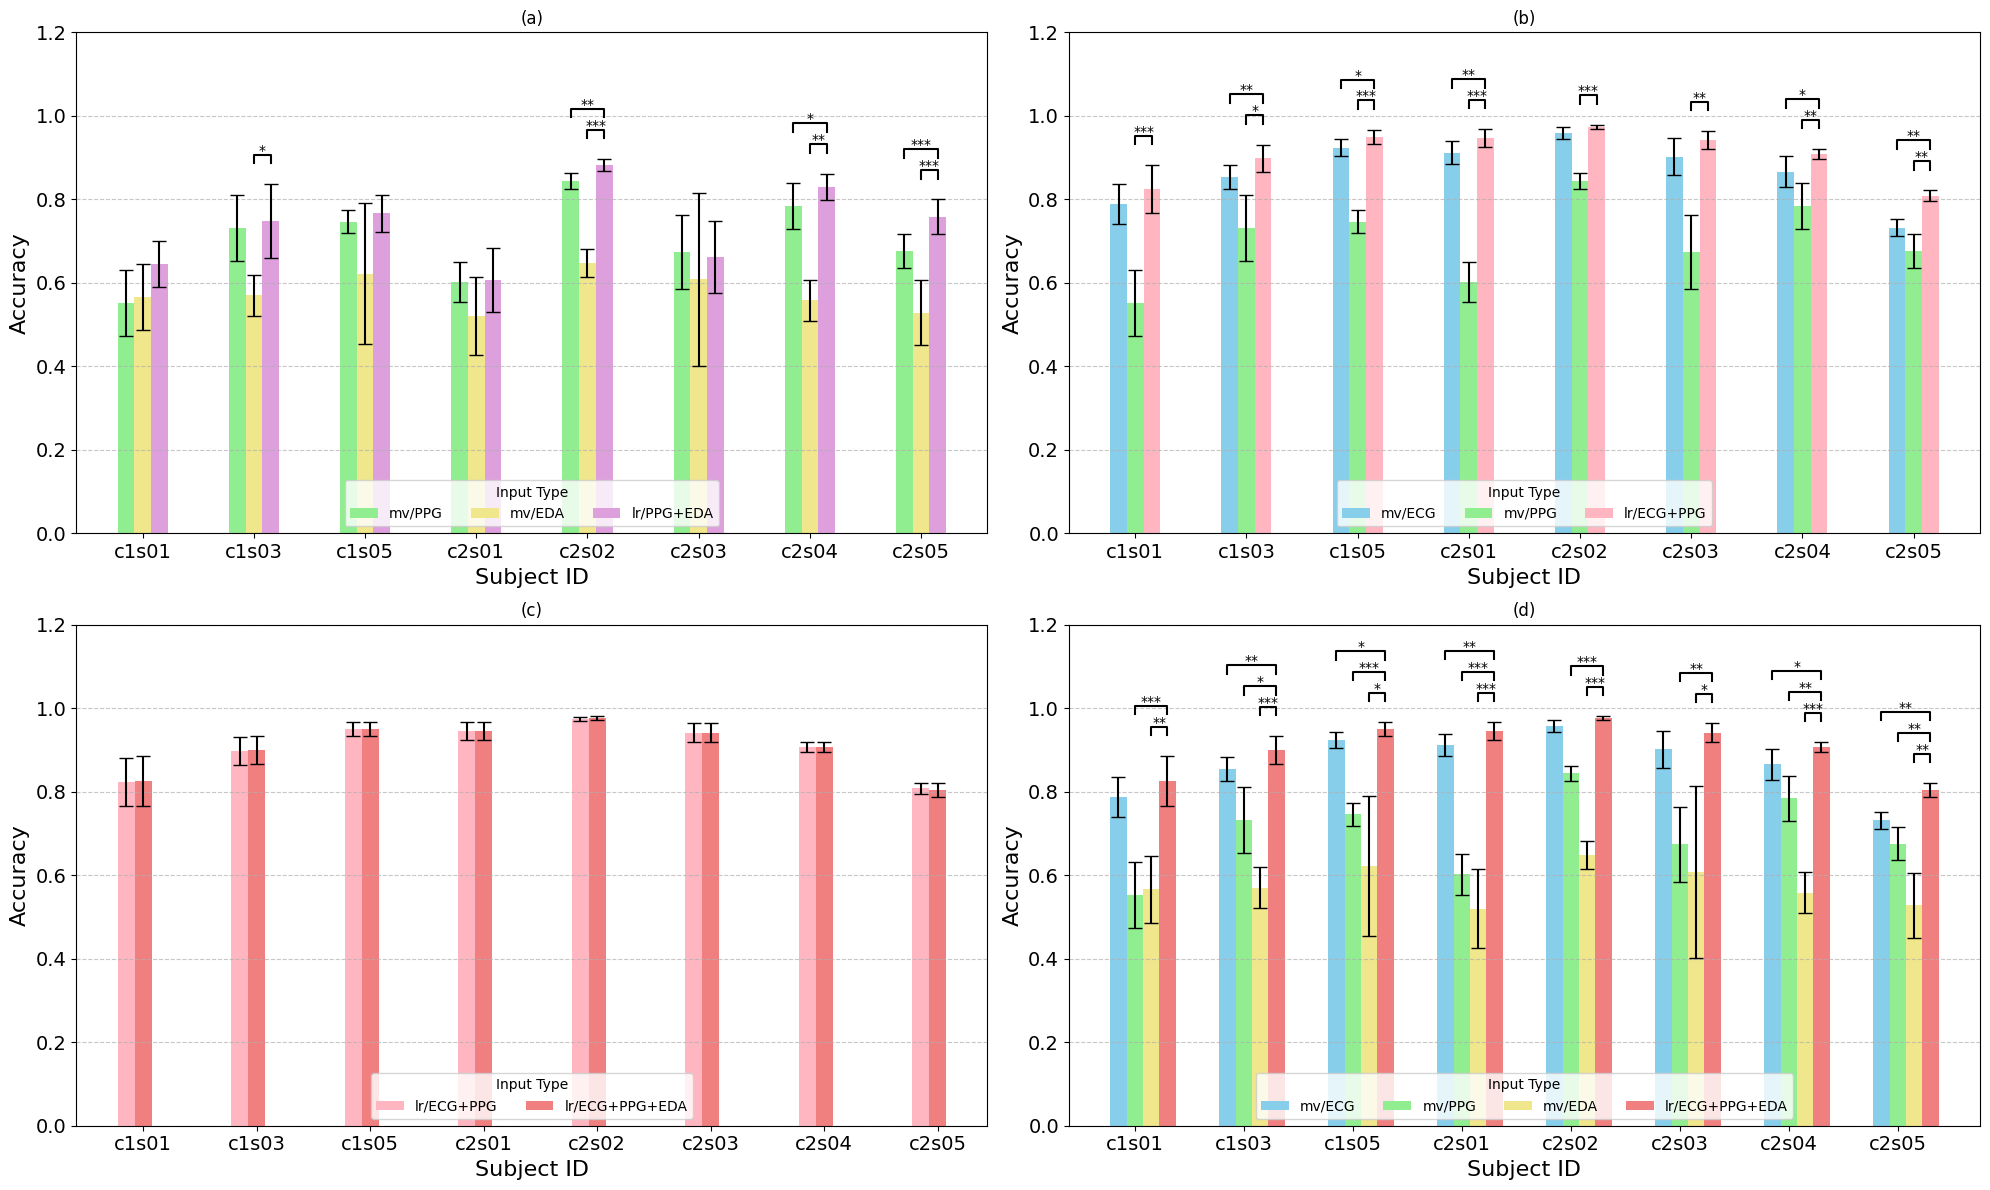

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

show_plot(axes[0, 0], cgm_results, ['mv/PPG', 'mv/EDA', 'lr/PPG+EDA'], title='(a)')
show_plot(axes[0, 1], cgm_results, ['mv/ECG', 'mv/PPG', 'lr/ECG+PPG'], title='(b)')
show_plot(axes[1, 0], cgm_results, ['lr/ECG+PPG', 'lr/ECG+PPG+EDA'], title='(c)')
show_plot(axes[1, 1], cgm_results, ['mv/ECG', 'mv/PPG', 'mv/EDA', 'lr/ECG+PPG+EDA'], title='(d)')
plt.tight_layout()
plt.show()

In [12]:
# # comparison between differnet models
# categories = ['lr/ECG+PPG+EDA','lr/ECG+PPG', 'lr/PPG+EDA']
# for subject_id in subjects:
#     for mode in range(1, 3):
#         MoE_results_path = './results/MoE_mode{}/{}/main.log'.format(mode, subject_id)
#         if not os.path.exists(MoE_results_path):
#             continue
#         mode_name = categories[mode]
#         MoE_cgm_accs = []
#         with open(MoE_results_path) as f:
#             lines = f.readlines()
#             for line in lines:
#                 if 'MoE' in line:
#                     acc = float(line.split(' ')[-1])
#                     MoE_cgm_accs.append(acc)
#         MoE_cgm_accs = np.array(MoE_cgm_accs)
#         cgm_results[subject_id][mode_name] = MoE_cgm_accs

# print(cgm_results)

In [13]:
# def show_plot(cgm_results, categories, title='CGM-Level Detection'):
#     # Process data for the bar plot
#     subject_ids = list(cgm_results.keys())
#     x = np.arange(len(subject_ids))
#     bar_width = 0.15

#     # Extract mean accuracy for each category per subject
#     mean_accuracies = {
#         category: [np.mean(cgm_results[subject_id][category]) for subject_id in subject_ids]
#         for category in categories
#     }

#     std_accuracies = {
#         category: [np.std(cgm_results[subject_id][category]) for subject_id in subject_ids]
#         for category in categories
#     }

#     # Plotting
#     fig, ax = plt.subplots(figsize=(20, 8))
#     # set the font size
#     plt.rcParams.update({
#         'font.size': 14, 
#         'axes.labelsize': 16, 
#         'axes.titlesize': 18, 
#         'xtick.labelsize': 12, 
#         'ytick.labelsize': 12
#     })

#     for i, category in enumerate(categories):
#         ax.bar(
#             x + i * bar_width,
#             mean_accuracies[category],
#             bar_width,
#             yerr=std_accuracies[category],
#             capsize=5,
#             label=category
#         )

#         # Add text labels
#         for j, (acc,std) in enumerate(zip(mean_accuracies[category],std_accuracies[category])):
#             ax.text(
#                 x[j] + i * bar_width - 0.05,
#                 acc + std + 0.01,
#                 "{:.2f}".format(acc),
#                 fontsize=12
#             )


#     # Formatting the plot
#     ax.set_xlabel('Subject ID')
#     ax.set_ylabel('Accuracy (Mean)')
#     ax.set_title(title)
#     ax.set_xticks(x + bar_width)
#     ax.set_xticklabels(subject_ids)
#     ax.set_ylim(0, 1.2)
#     ax.legend(title="Input Type", loc='lower right')
#     ax.grid(axis='y', linestyle='--', alpha=0.7)

#     # Show the plot
#     plt.tight_layout()
#     plt.show()


In [14]:
def show_boxplot(cgm_results, categories, title='CGM-Level Detection', show_text=False):
    """
    Display a box plot for CGM-level detection accuracy grouped by subject and category.

    Args:
        cgm_results (dict): Dictionary containing CGM detection results for each subject and category.
        categories (list): List of category names.
        title (str): Title of the plot.
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    import numpy as np

    # Process data for the box plot
    subject_ids = list(cgm_results.keys())
    boxplot_data_grouped = {category: [] for category in categories}

    for category in categories:
        for subject_id in subject_ids:
            boxplot_data_grouped[category].append(cgm_results[subject_id][category])

    # Configure plot styling
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.rcParams.update({
        'font.size': 14,
        'axes.labelsize': 16,
        'axes.titlesize': 18,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
    })

    group_width = 0.8
    category_width = group_width / len(categories)
    offset = -(len(categories) - 1) / 2 * category_width

    # Plot grouped box plots
    positions = []
    colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral', 'lightpink']

    for i, category in enumerate(categories):
        category_positions = [x + offset + i * category_width for x in range(len(subject_ids))]
        positions.extend(category_positions)
        
        # Extract data for this category
        data_for_category = boxplot_data_grouped[category]
        
        # Plot boxplots
        bp = ax.boxplot(
            data_for_category,
            positions=category_positions,
            widths=category_width * 0.9,
            patch_artist=True,
            boxprops=dict(facecolor=colors[i], color='black'),
            showmeans=True,
            meanline=True,
            meanprops=dict(color='black', linestyle='--'),
            medianprops=dict(color='red', linewidth=1.5)
        )
        
        # Add mean text on the plot
        if show_text:
            means = [np.mean(data) for data in data_for_category]
            for pos, mean in zip(category_positions, means):
                ax.text(pos, mean, f'{mean:.2f}', ha='center', va='bottom', fontsize=10, color='black')

    # Formatting the plot
    ax.set_xticks(range(len(subject_ids)))
    ax.set_xticklabels(subject_ids, rotation=30, ha='right')
    ax.set_xlabel('Subject ID')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 1.2)

    # Add a legend for categories
    legend_patches = [Patch(facecolor=colors[i], label=category) for i, category in enumerate(categories)]
    ax.legend(legend_patches, categories, title="Input Type", loc='lower right')

    plt.tight_layout()
    plt.show()


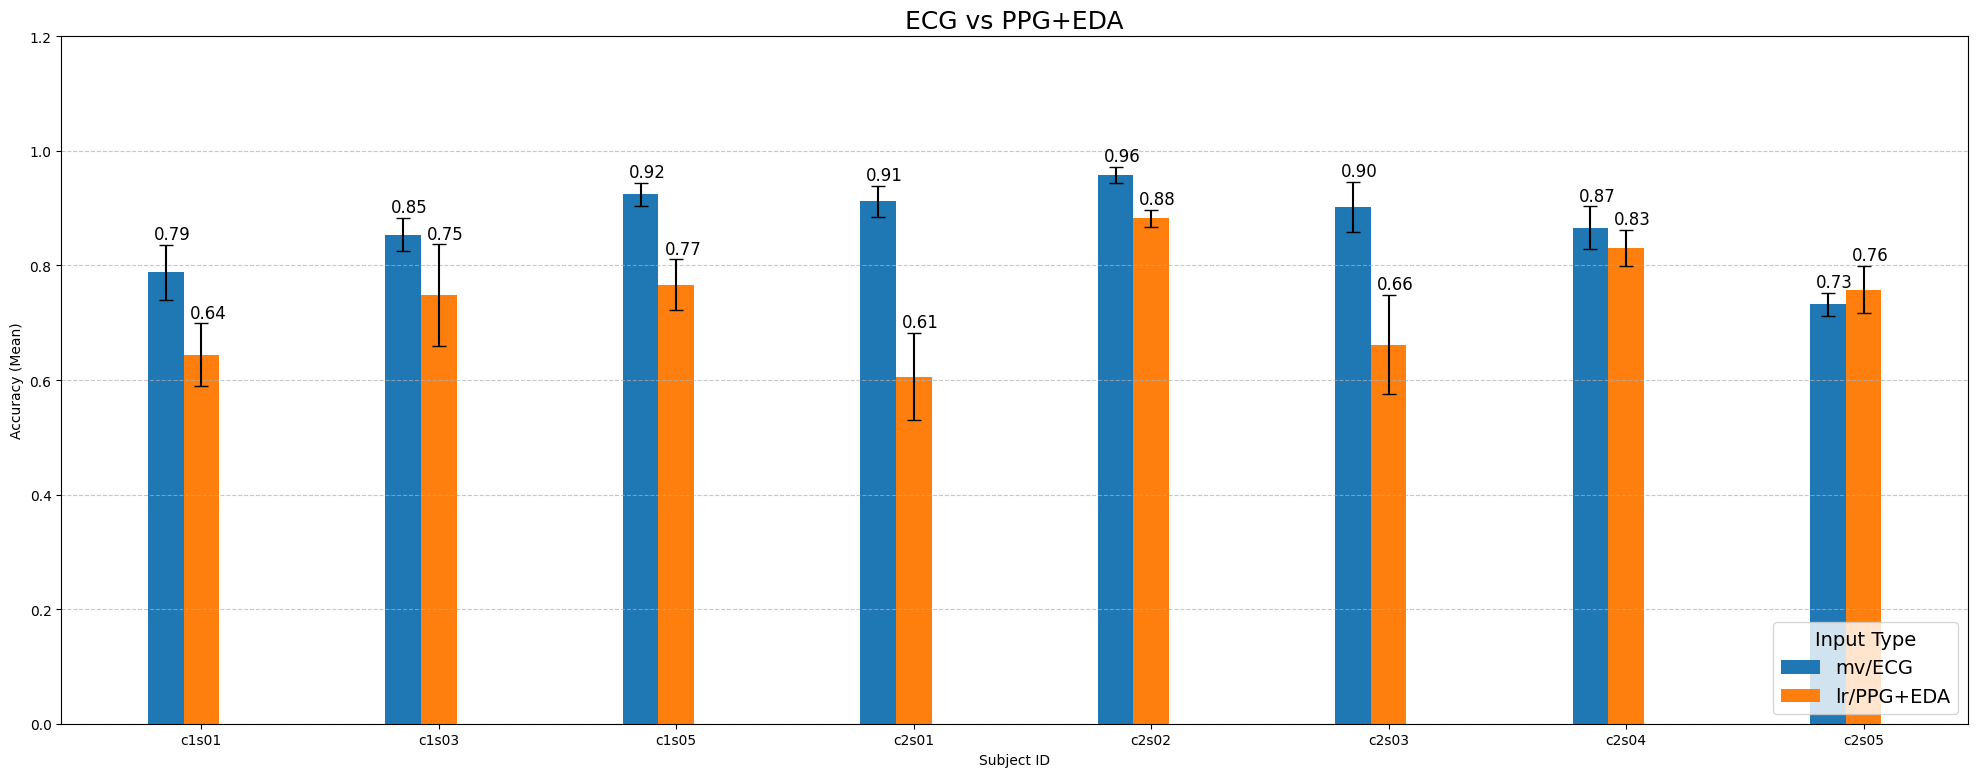

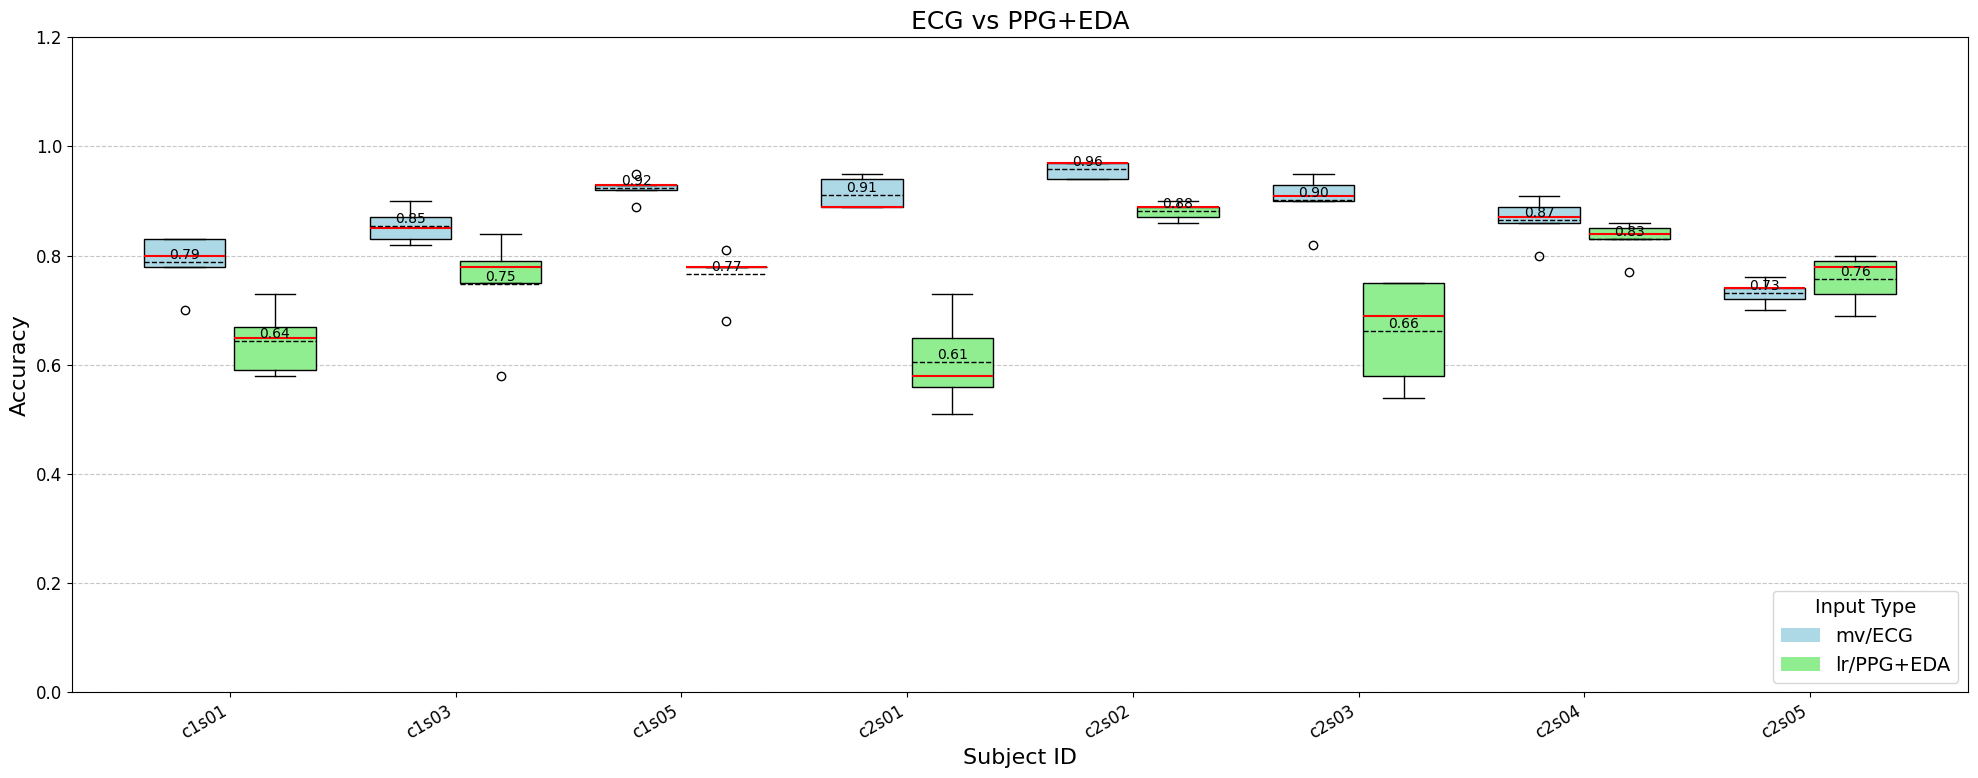

In [15]:
show_plot(cgm_results, ['mv/ECG', 'lr/PPG+EDA'], title='ECG vs PPG+EDA')
show_boxplot(cgm_results, ['mv/ECG', 'lr/PPG+EDA'], title='ECG vs PPG+EDA', show_text=True)

<Axes: title={'center': 'EDA vs EDA+TEMP'}, xlabel='Subject ID', ylabel='Accuracy'>

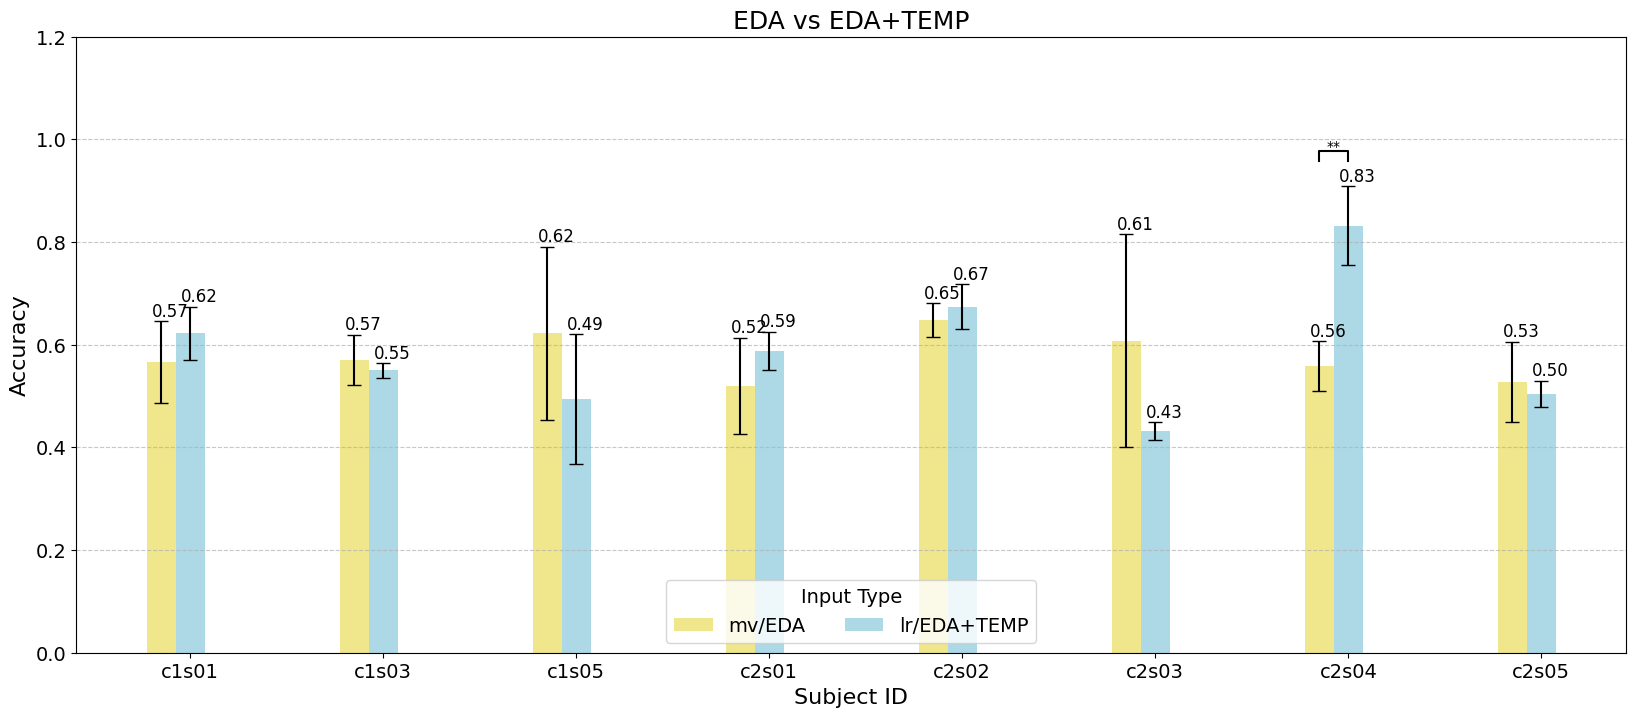

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(20, 8))
show_plot(axes, cgm_results, ['mv/EDA', 'lr/EDA+TEMP'], title='EDA vs EDA+TEMP', show_text=True)

# show_boxplot(cgm_results, ['mv/EDA', 'lr/EDA+TEMP'], title='EDA vs EDA+TEMP', show_text=True)

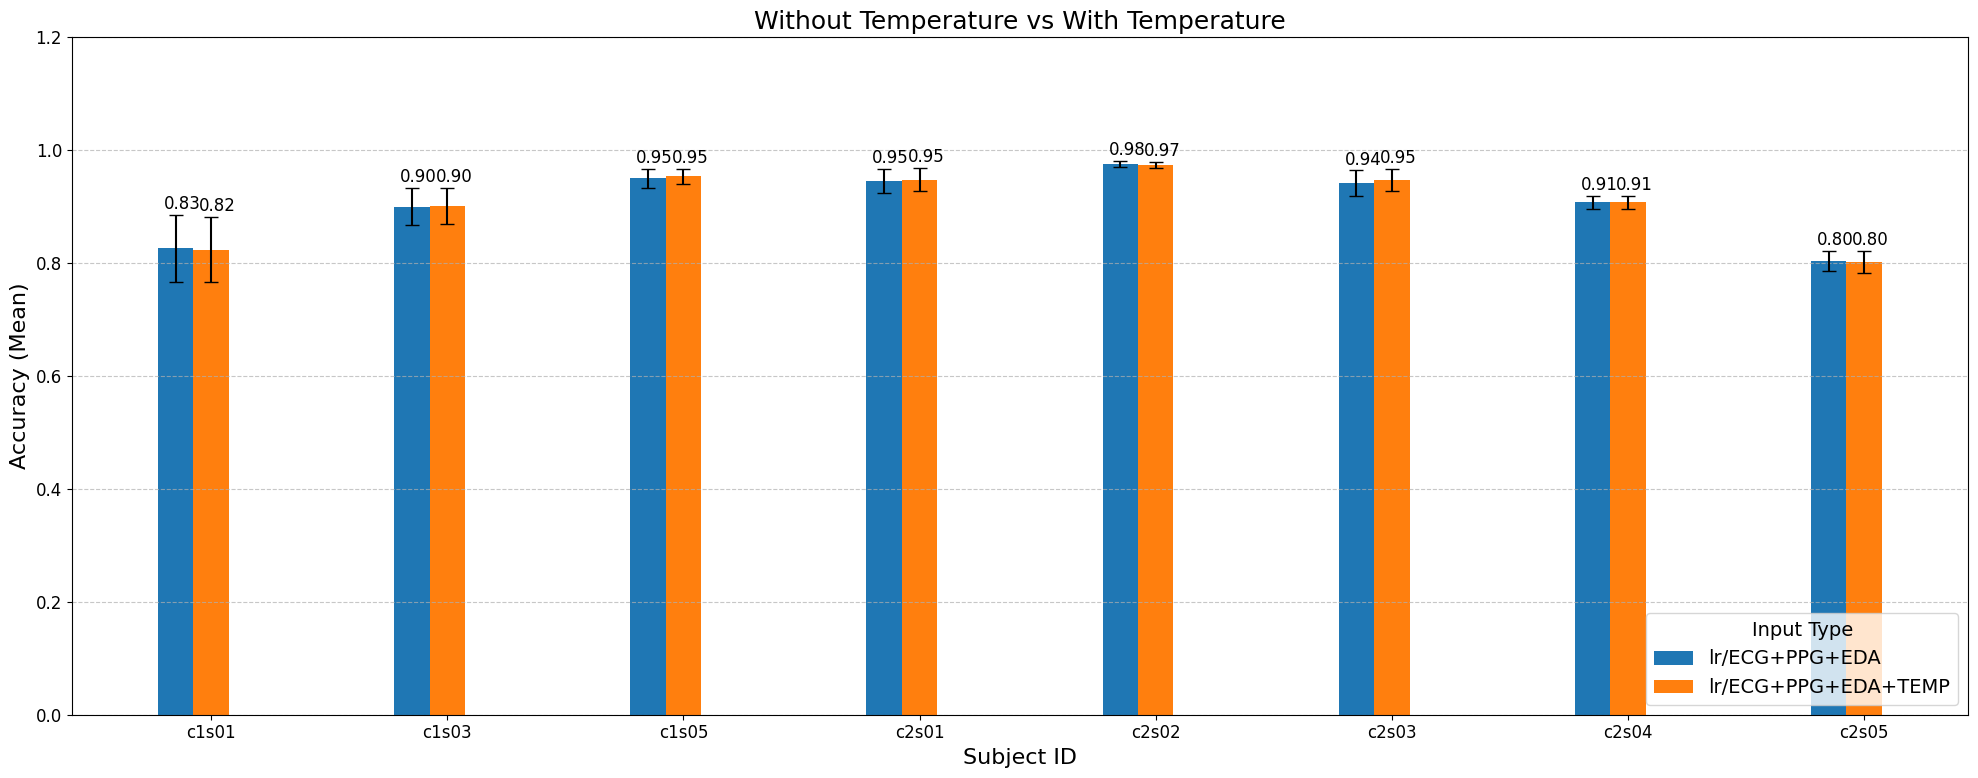

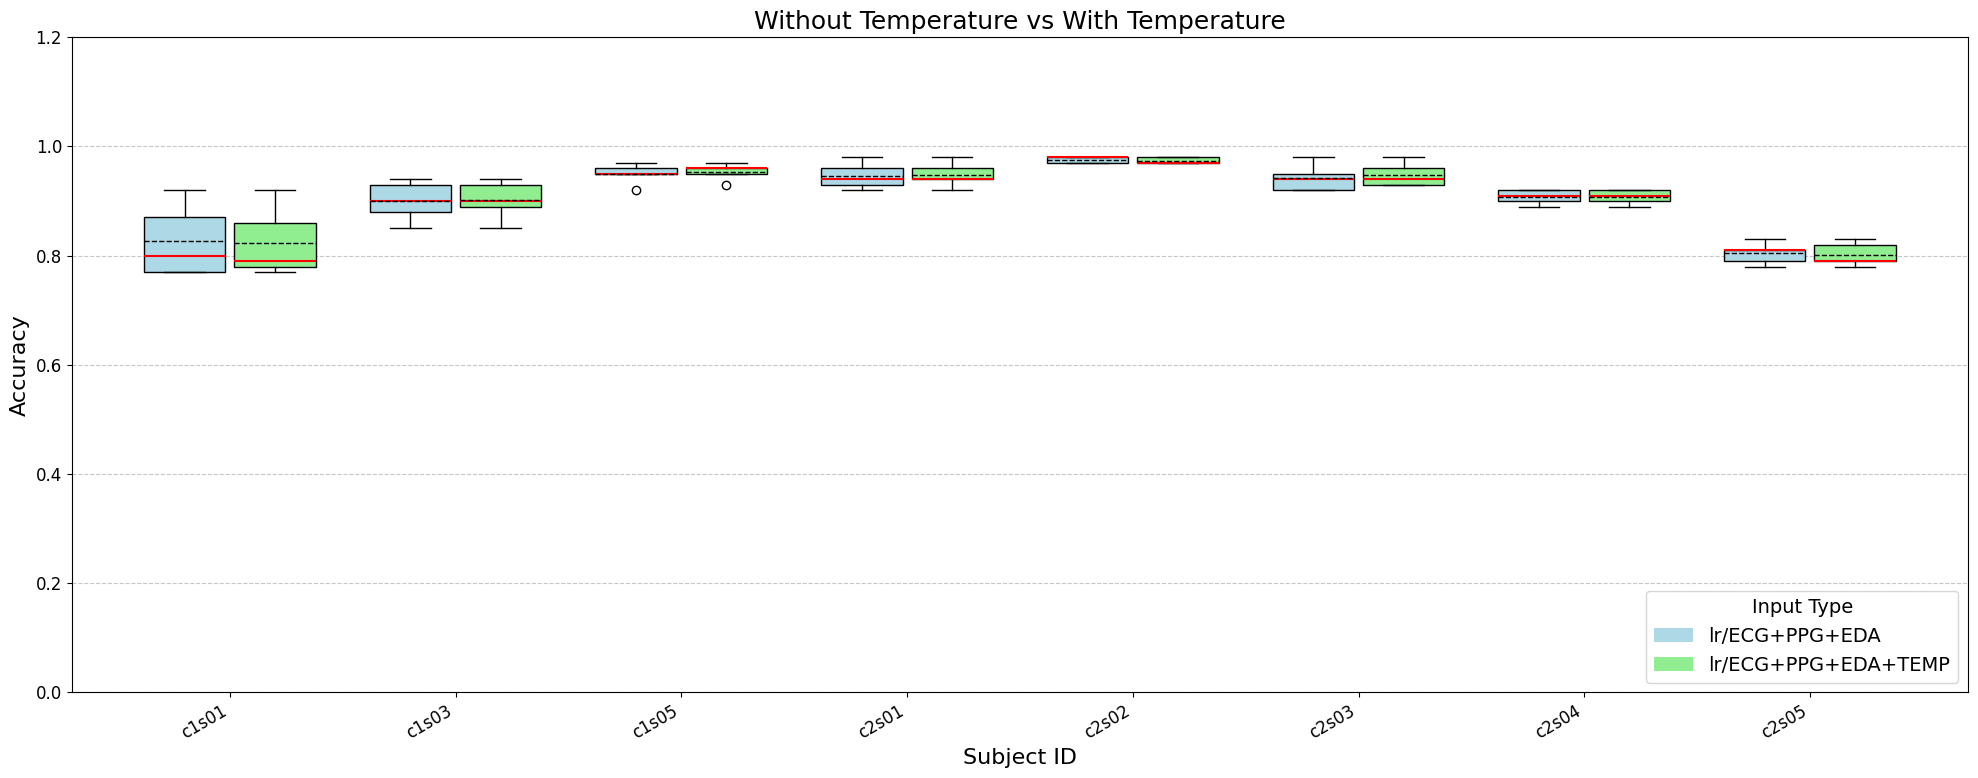

In [17]:
show_plot(cgm_results, ['lr/ECG+PPG+EDA', 'lr/ECG+PPG+EDA+TEMP'], title='Without Temperature vs With Temperature')
show_boxplot(cgm_results, ['lr/ECG+PPG+EDA', 'lr/ECG+PPG+EDA+TEMP'], title='Without Temperature vs With Temperature')

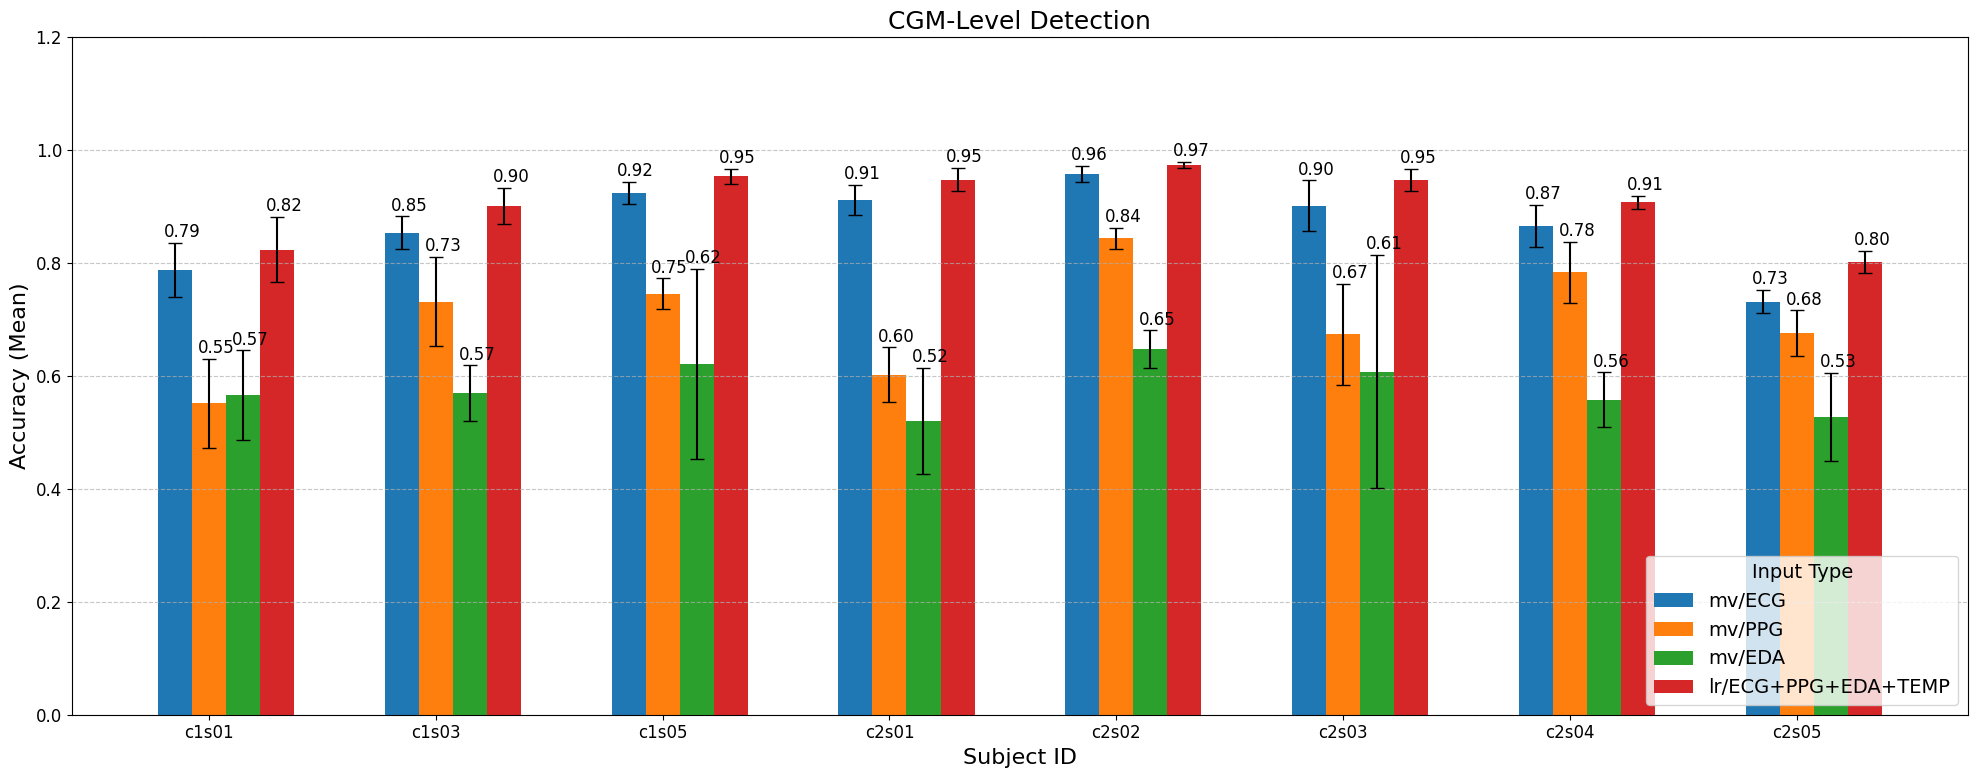

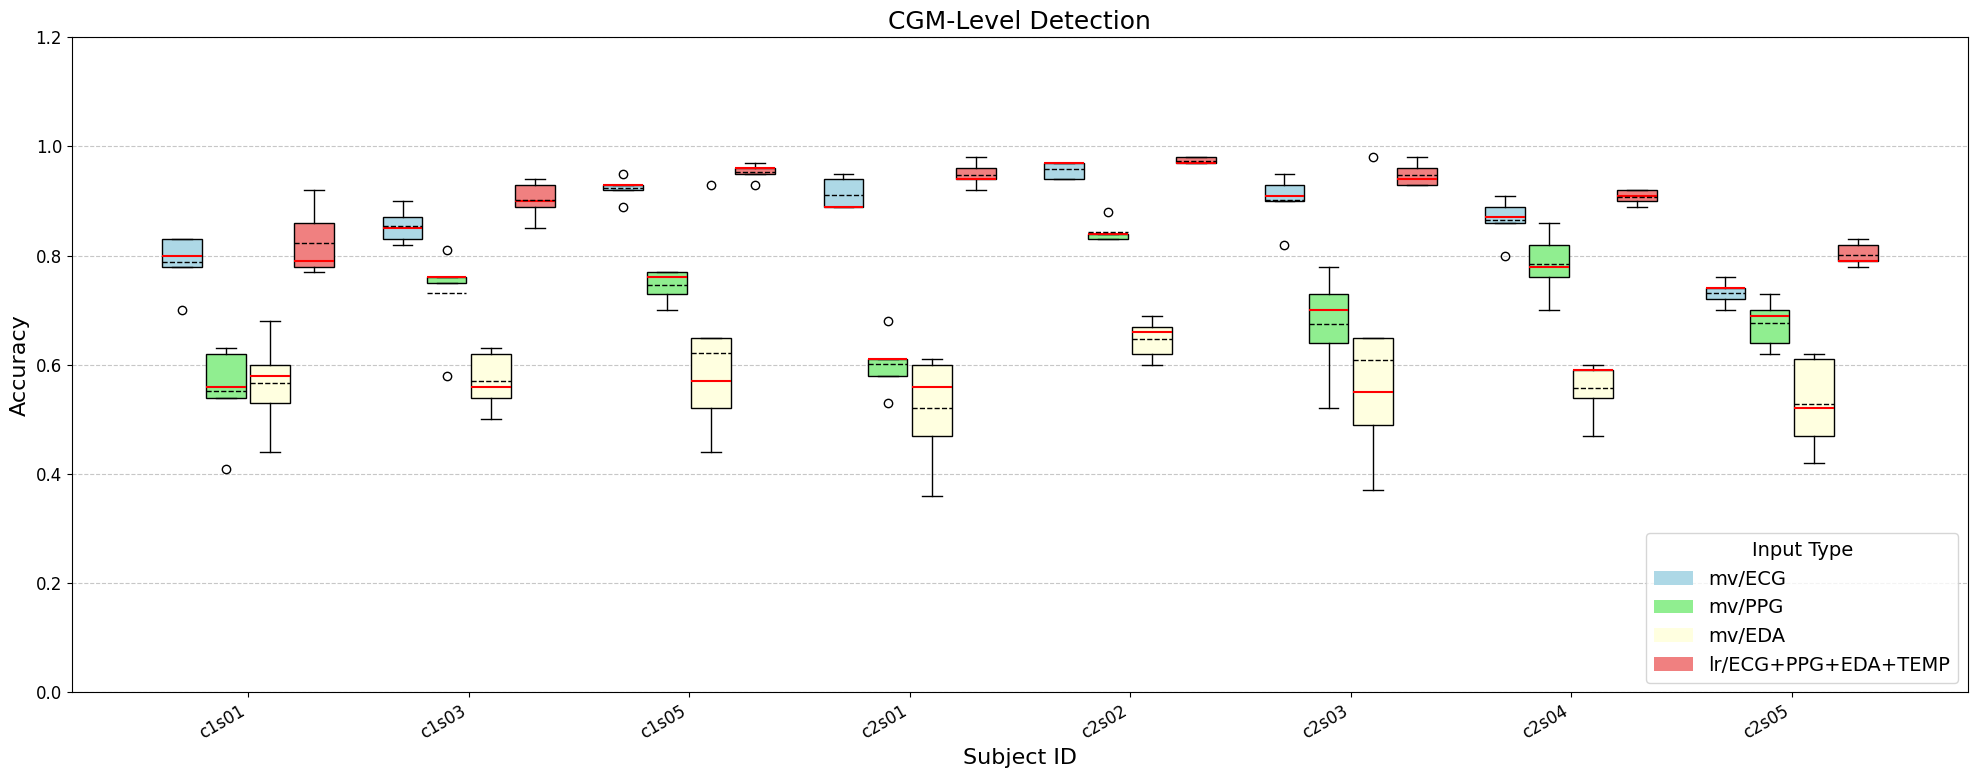

In [18]:
show_plot(cgm_results, ['mv/ECG', 'mv/PPG', 'mv/EDA', 'lr/ECG+PPG+EDA+TEMP'], title='CGM-Level Detection')
show_boxplot(cgm_results, ['mv/ECG', 'mv/PPG', 'mv/EDA', 'lr/ECG+PPG+EDA+TEMP'], title='CGM-Level Detection')

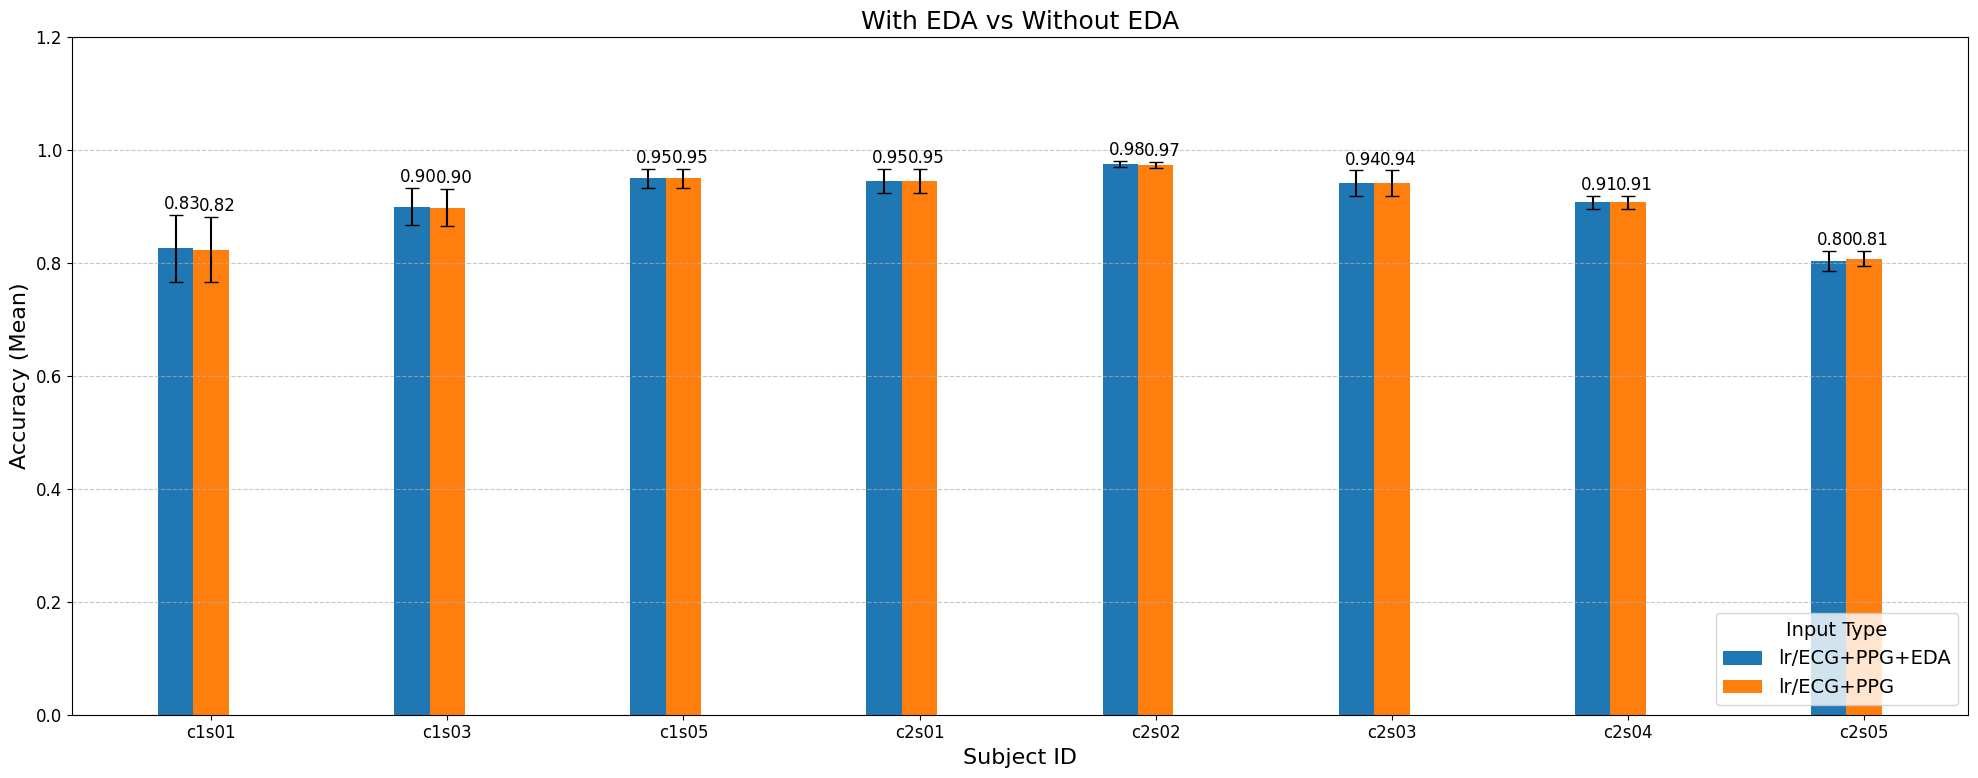

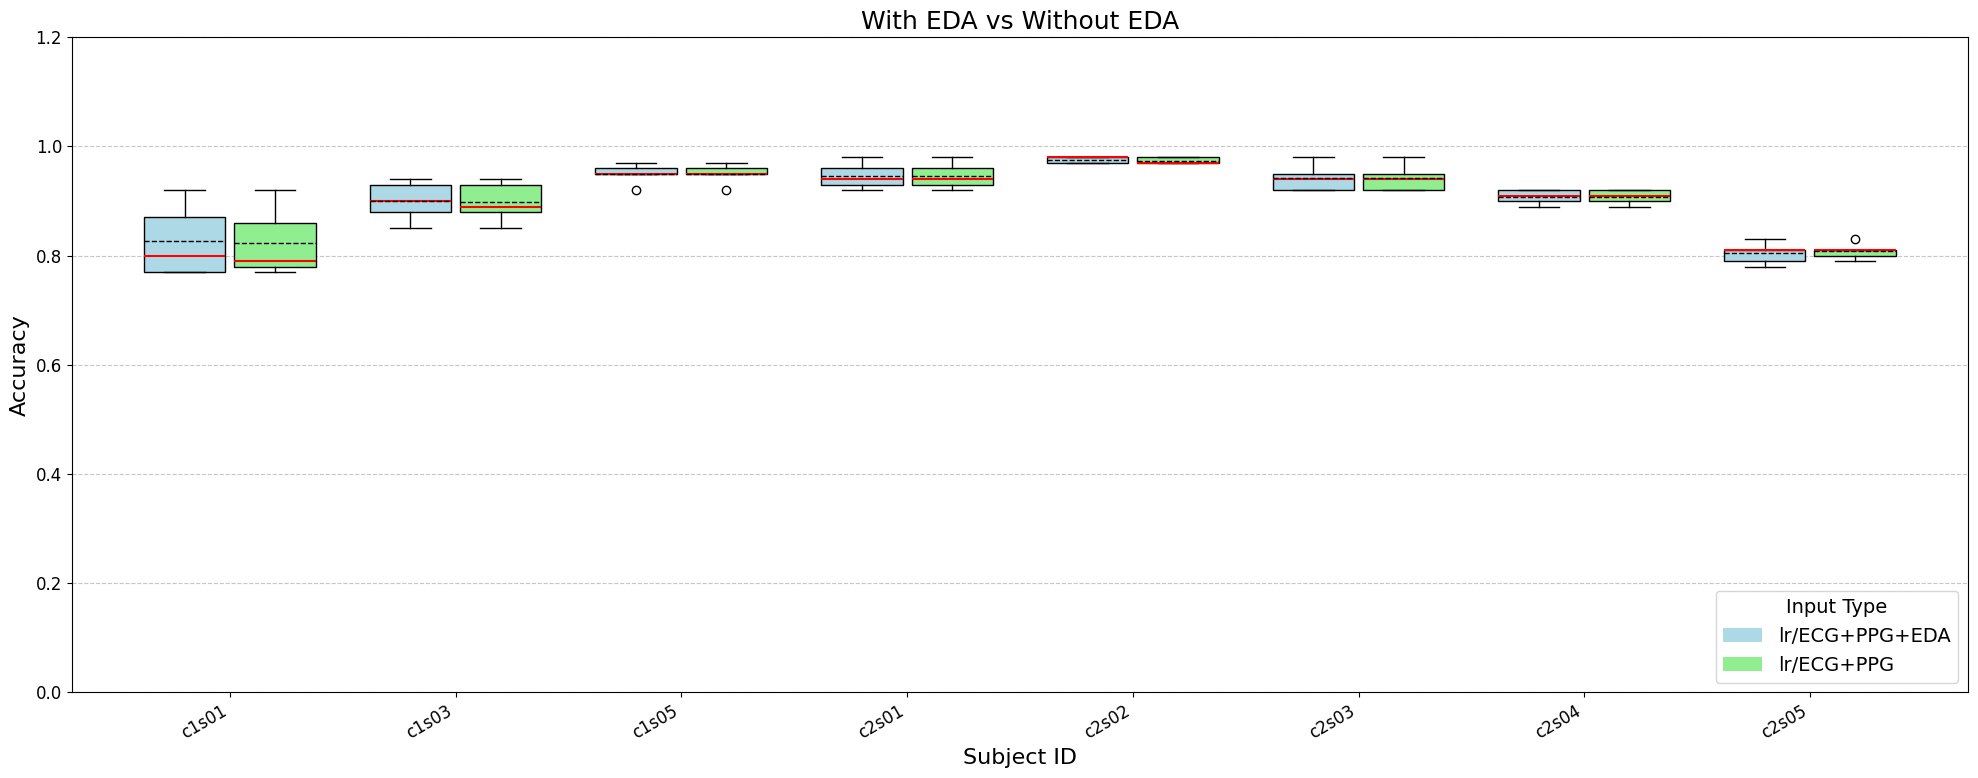

In [19]:
show_plot(cgm_results, ['lr/ECG+PPG+EDA', 'lr/ECG+PPG'], title='With EDA vs Without EDA')
show_boxplot(cgm_results, ['lr/ECG+PPG+EDA', 'lr/ECG+PPG'], title='With EDA vs Without EDA')

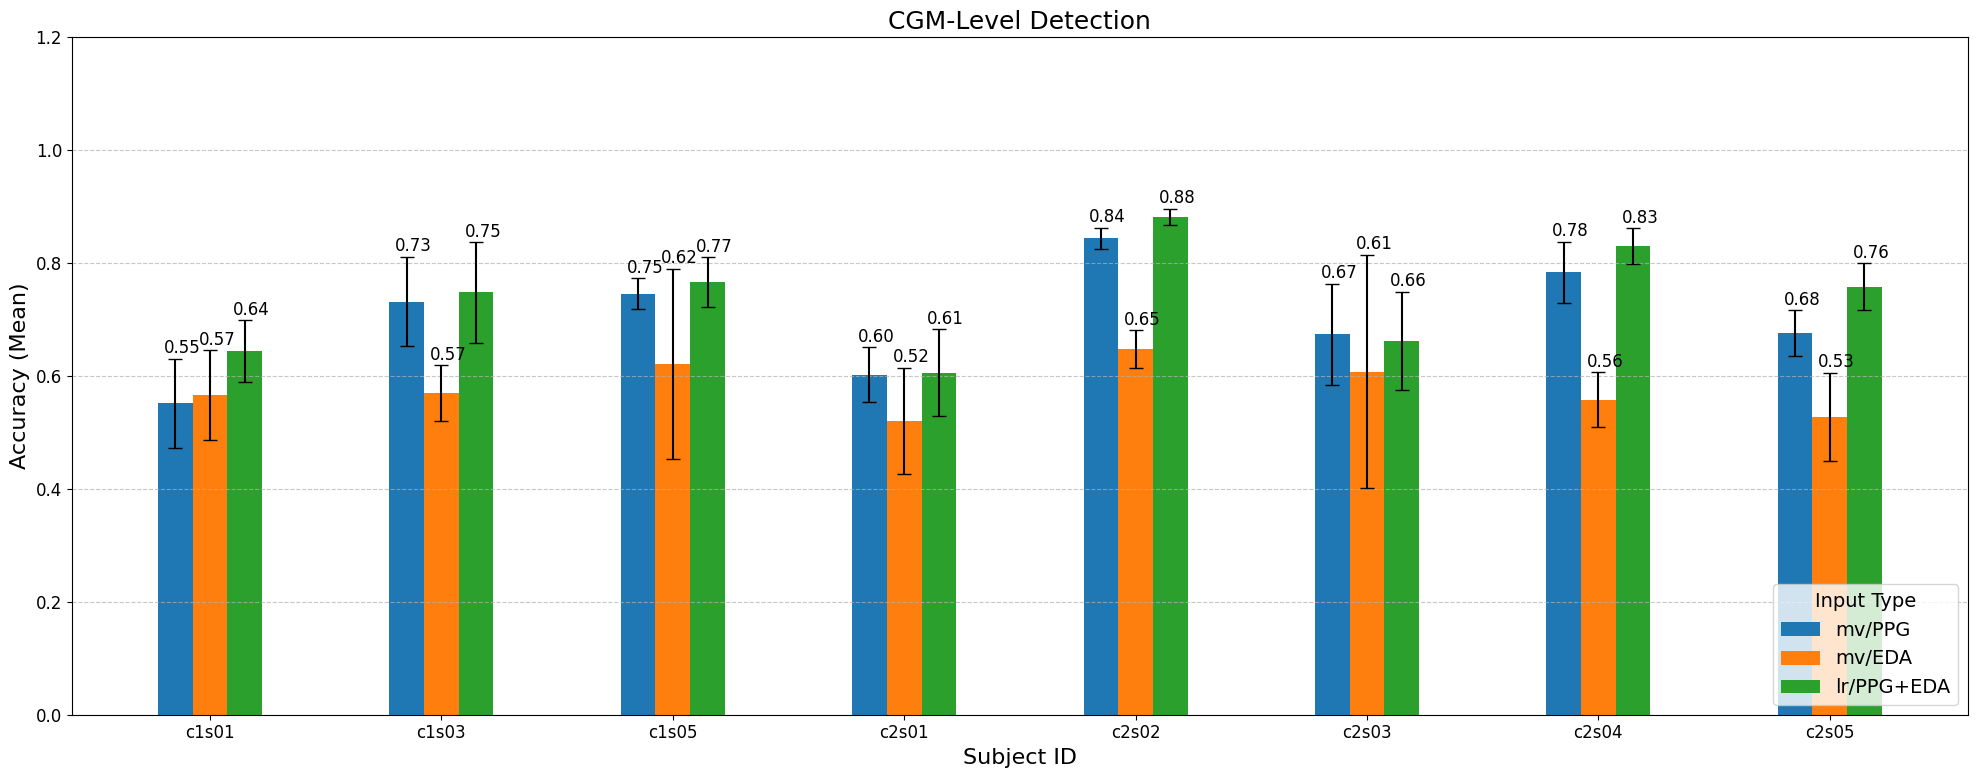

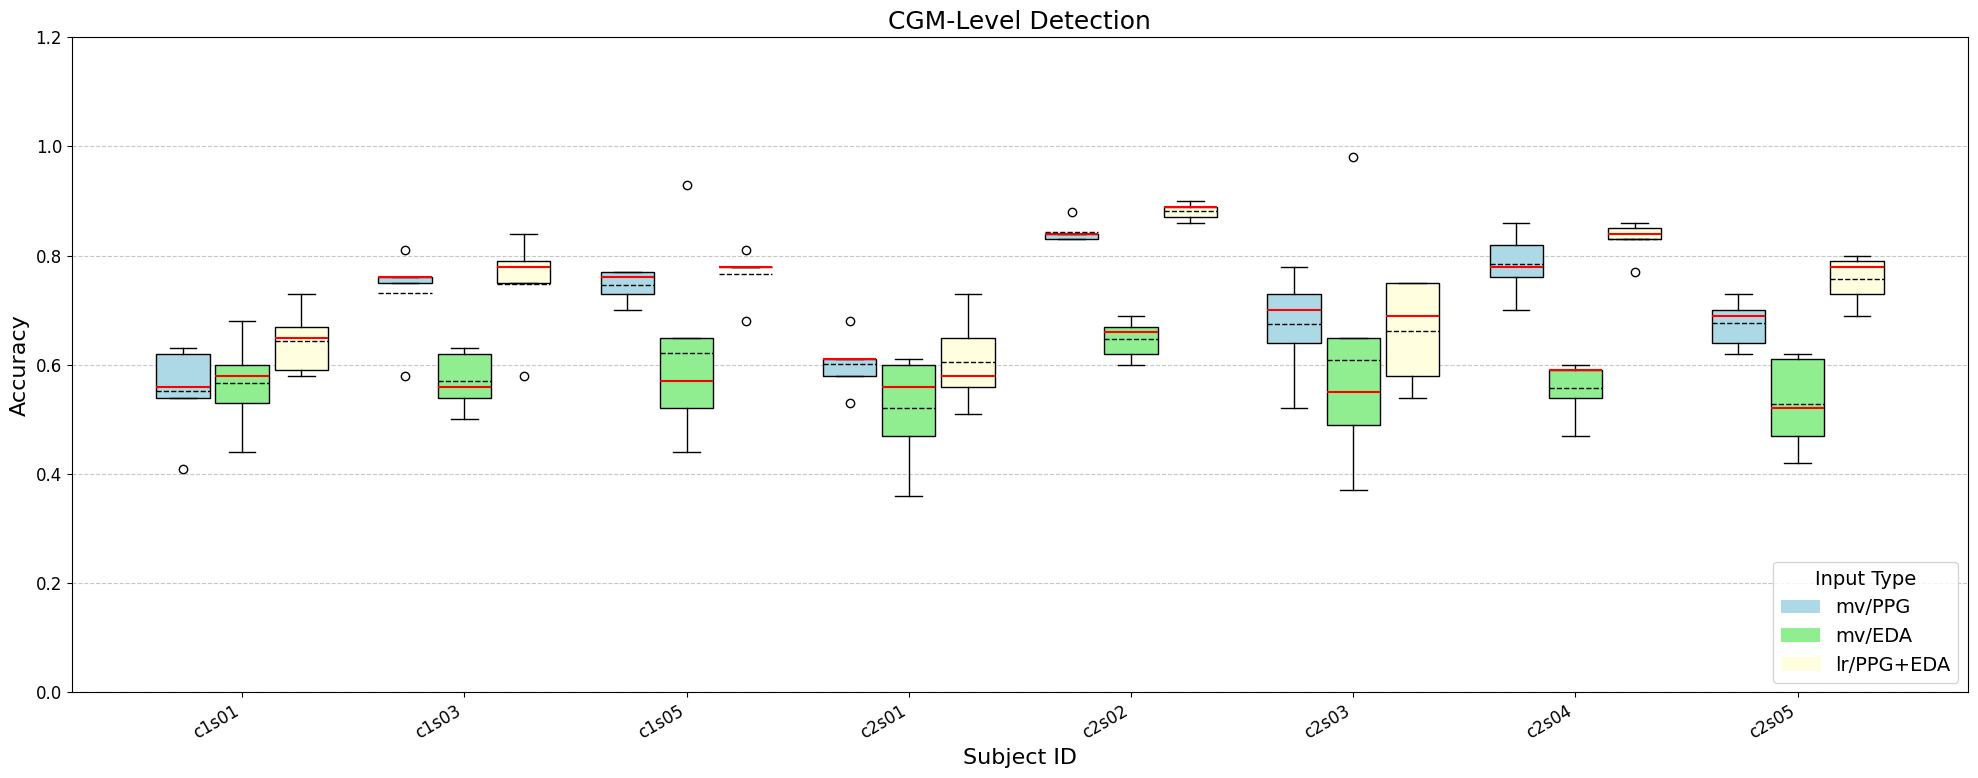

In [20]:
show_plot(cgm_results, ['mv/PPG', 'mv/EDA', 'lr/PPG+EDA'], title='CGM-Level Detection')
show_boxplot(cgm_results, ['mv/PPG', 'mv/EDA', 'lr/PPG+EDA'], title='CGM-Level Detection')

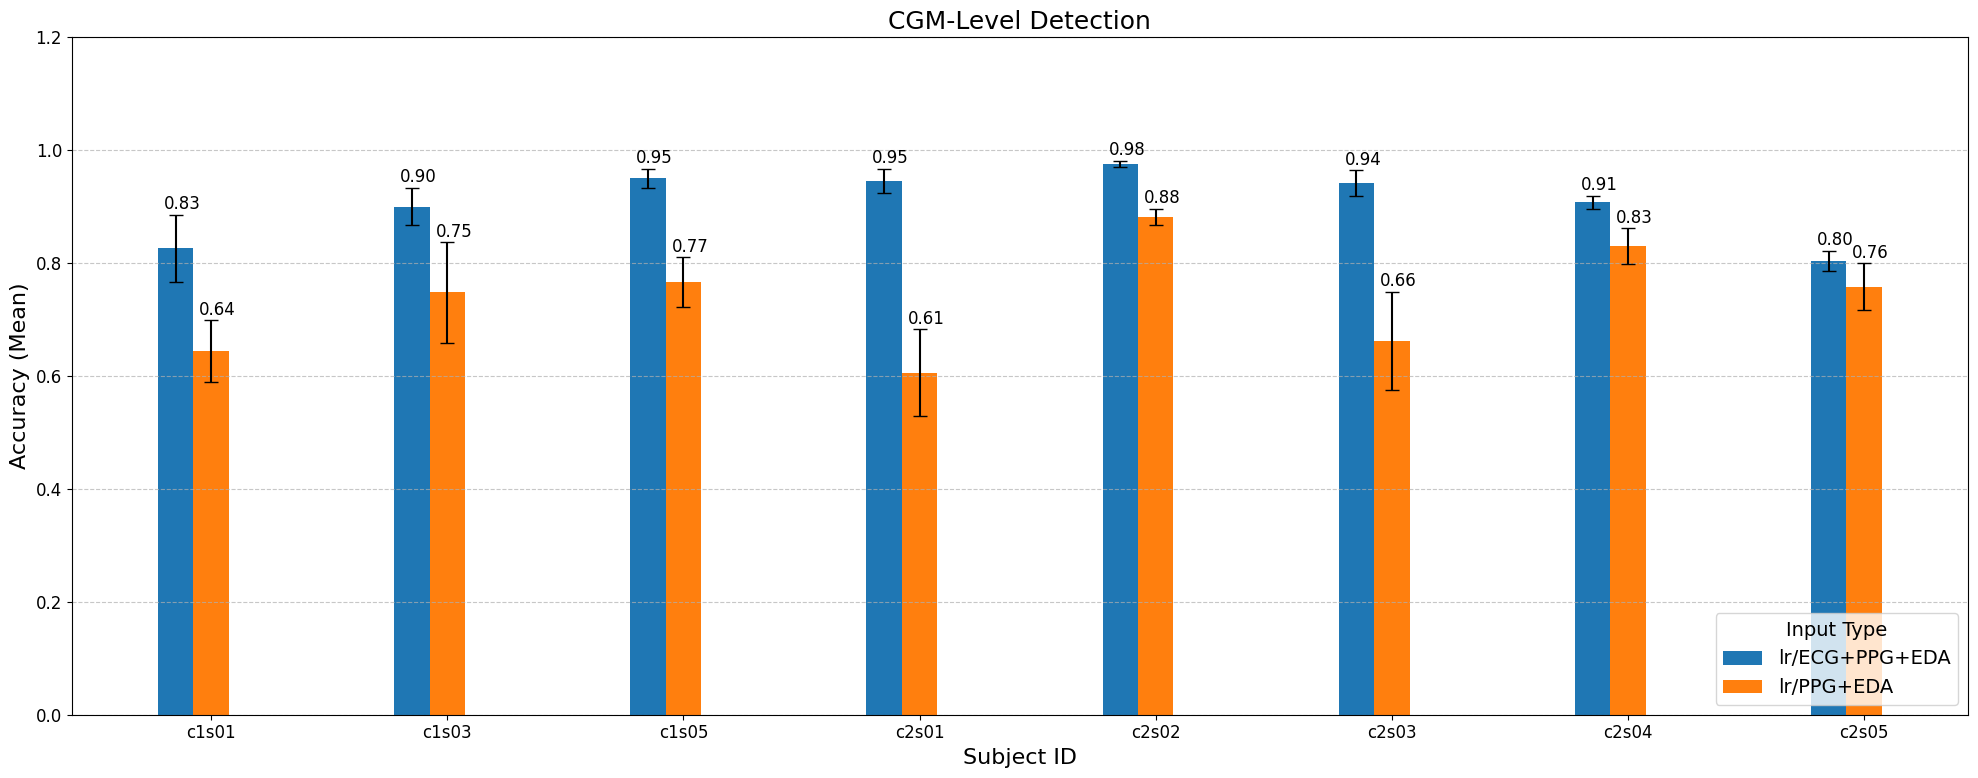

In [21]:
show_plot(cgm_results, ['lr/ECG+PPG+EDA', 'lr/PPG+EDA'])

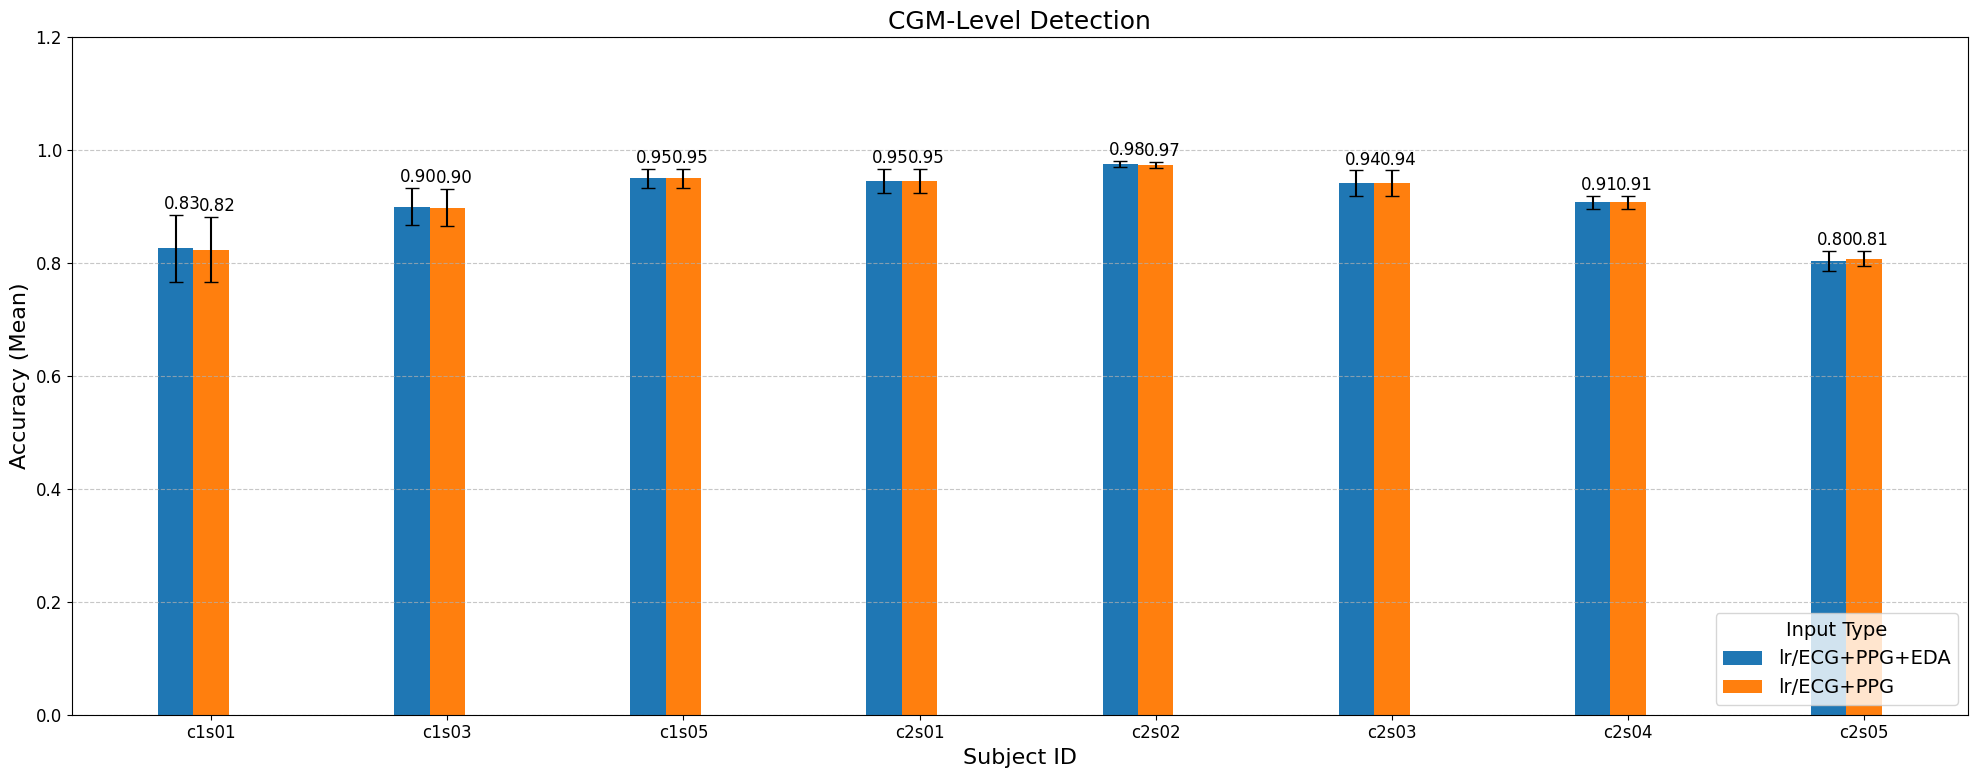

In [22]:
show_plot(cgm_results, ['lr/ECG+PPG+EDA', 'lr/ECG+PPG'])

In [23]:
# import pandas as pd

# data = {
#     "Variant": [
#         "mv/ECG", "mv/PPG", "mv/EDA", 
#         "lr/ECG+PPG", "lr/PPG+EDA", 
#         "lr/ECG+PPG+EDA", "lr_mv/ECG+PPG+EDA"
#     ],
# }
# for subject_id in subjects:
#     for variant in data["Variant"]:
#         if variant in cgm_results[subject_id]:
#             if subject_id not in data:
#                 data[subject_id] = []
#             data[subject_id].append(np.mean(cgm_results[subject_id][variant]))

# # Calculate the average accuracy for each variant
# data["Average"] = []
# for i, variant in enumerate(data["Variant"]):
#     data["Average"].append(np.mean([data[subject_id][i] for subject_id in subjects]))


# # Create the DataFrame
# df = pd.DataFrame(data)
# for col in df.columns[1:]:  # Exclude 'Variant' and 'Average'
#     df[col] = df[col].apply(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

# # Generate LaTeX code
# latex_code = df.to_latex(index=False, column_format="lcccccccc|c", 
#                          caption="Comparison of accuracy at EER.", 
#                          label="tab:comparison", 
#                          escape=False, 
#                          bold_rows=False)

# # Print the LaTeX code
# print(latex_code)


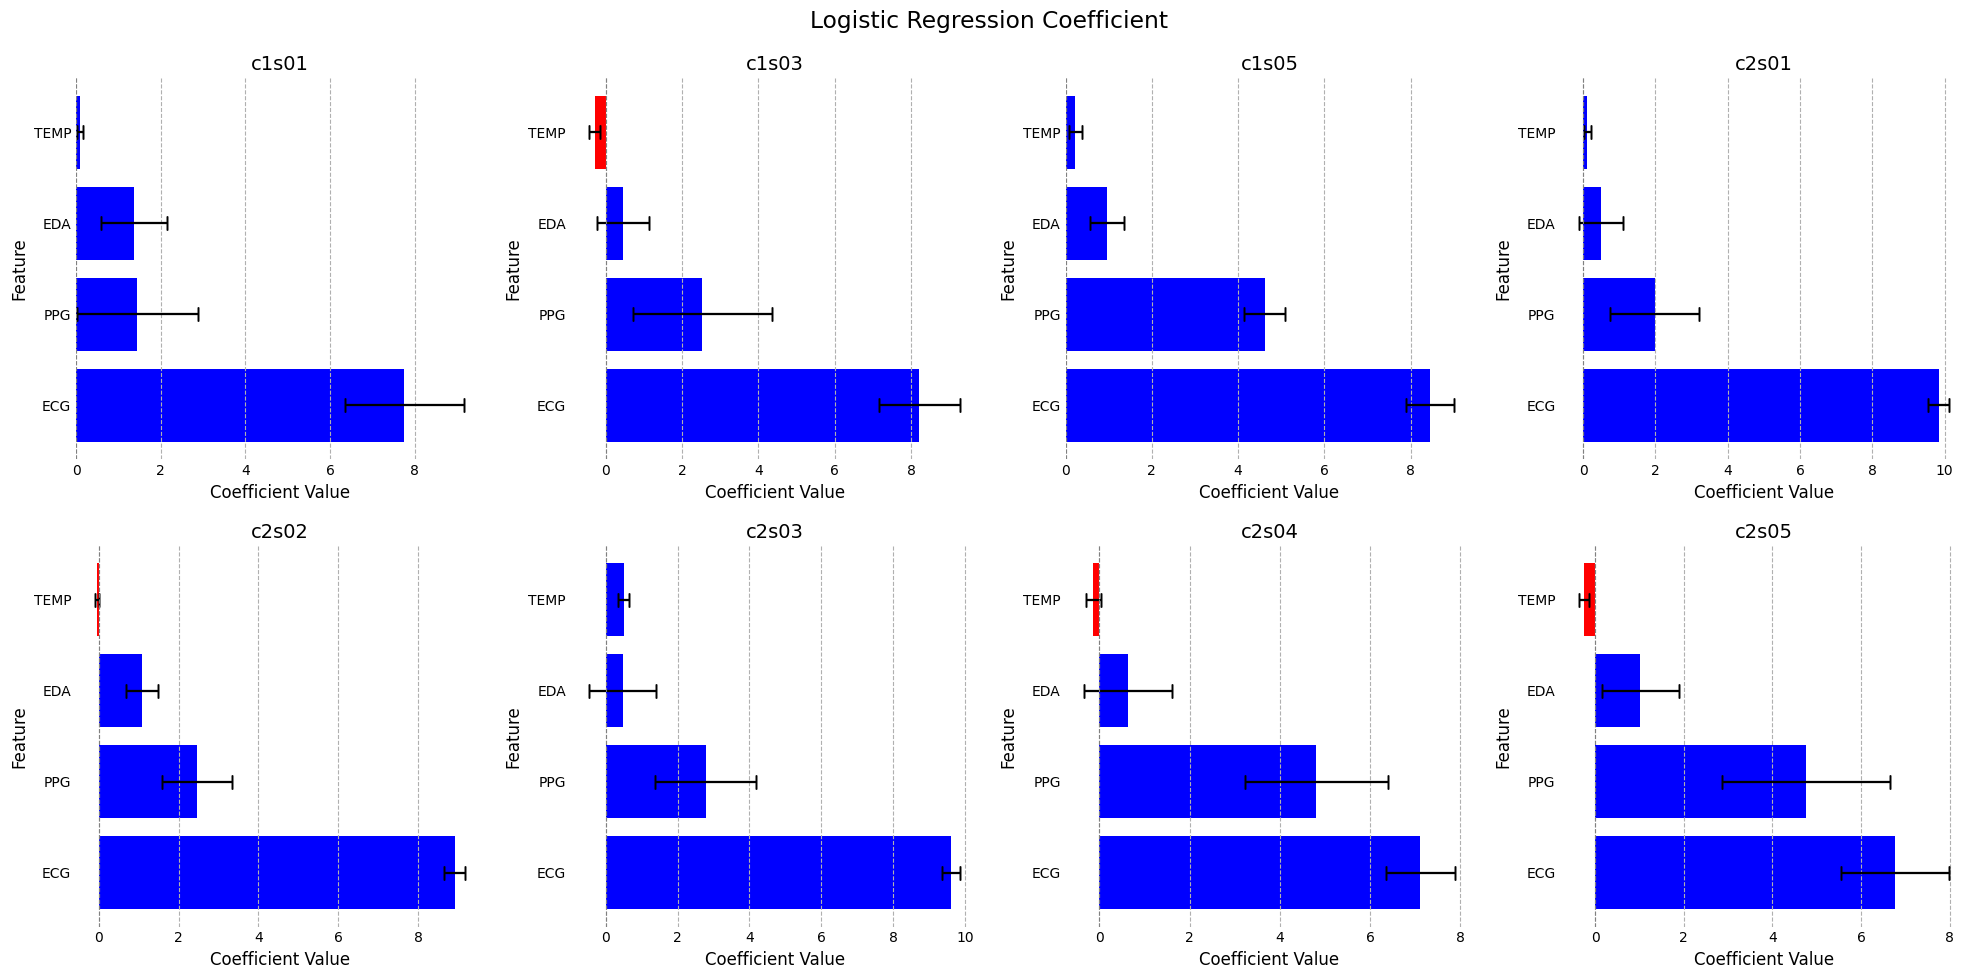

In [24]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification


fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i, subject_id in enumerate(subject_ids):

    importance = defaultdict(list)
    for k in range(5):
        train_data = pd.read_csv(f'../results/MoE_avgp/{subject_id}/v{k+1}/MoE_train.csv')
        val_data = pd.read_csv(f'../results/MoE_avgp/{subject_id}/v{k+1}/MoE_val.csv')
        
        model = LogisticRegression(class_weight='balanced')
        model.fit(train_data[['ecg', 'ppg', 'eda', 'temp']], train_data['label'])

        coefficients = model.coef_[0]
        importance['ECG'].append(coefficients[0])
        importance['PPG'].append(coefficients[1])
        importance['EDA'].append(coefficients[2])
        importance['TEMP'].append(coefficients[3])


    importance = pd.DataFrame(importance)
    for _ in range(3):
        ax[i//4, i%4].barh(
            importance.columns,
            importance.mean(),
            xerr=importance.std(),
            capsize=5,
            color=np.where(importance.mean() > 0, 'blue', 'red')
        )

    ax[i//4, i%4].set_xlabel("Coefficient Value", fontsize=12)
    ax[i//4, i%4].set_ylabel("Feature", fontsize=12)
    ax[i//4, i%4].set_title(f"{subject_id}", fontsize=14)
    ax[i//4, i%4].axvline(x=0, color='gray', linestyle='--', linewidth=0.8)  # Line at zero for reference
    ax[i//4, i%4].set_yticks([0, 1, 2, 3])
    ax[i//4, i%4].set_yticklabels(['ECG', 'PPG', 'EDA', 'TEMP'])
    ax[i//4, i%4].grid(axis='x', linestyle='--', linewidth=0.8)
    ax[i//4, i%4].spines['top'].set_visible(False)
    ax[i//4, i%4].spines['right'].set_visible(False)
    ax[i//4, i%4].spines['bottom'].set_visible(False)
    ax[i//4, i%4].spines['left'].set_visible(False)
    ax[i//4, i%4].tick_params(axis='both', which='both', length=0)
    ax[i//4, i%4].tick_params(axis='x', which='major', labelsize=10)
    ax[i//4, i%4].tick_params(axis='y', which='major', labelsize=10)

plt.suptitle('Logistic Regression Coefficient')
plt.tight_layout()
plt.show()
